<a href="https://colab.research.google.com/github/euan-nr/TTC-Incident-Reporting/blob/main/TTC_Delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [ ]:
#Pull Delay Codes
codes_sub=gc.open_by_url("https://docs.google.com/spreadsheets/d/1h5eQZ2vosuBK7w4nUGVBtkdeU7jaPqtRyk6CbUp1oxs/edit#gid=1925460578").sheet1
values = codes_sub.get_all_values()
codes_sub = pd.DataFrame(values[1:],columns=values[0])
codes_srt=gc.open_by_url("https://docs.google.com/spreadsheets/d/12VERUjC0vH_IXXMjwPE5i3aPZjOXhONBvZtpvvRxXxU/edit#gid=2004182443").sheet1
values = codes_srt.get_all_values()
codes_srt = pd.DataFrame(values[1:],columns=values[0])

In [ ]:
#Pull all TTC delay reports from 2018-22
ttc2018 = gc.open_by_url('https://docs.google.com/spreadsheets/d/10TuyNMtIPxV-f6ipie52ZSH_S0Q3u-vbZcowTvbjriw/edit#gid=608361424')
ttc2019 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1niNiXHoWzEnJQ6FMxWcqybMUy9SLwn5p9exX6XM3EbI/edit#gid=1588468639')
ttc2020 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1HU5Ydhddg9FbFIWOgd7rbd_ybWfE2mWjYF5H8NesVGM/edit#gid=709672757')
ttc2021 = gc.open_by_url('https://docs.google.com/spreadsheets/d/15VCs-DbYX5LRy3Pdq_XOZViqpHXFum5wwwNtOxPT05I/edit#gid=608057869')
ttc2022 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1cmAnAFmol51KvdVYvXWElBKGwpU8fUZtBIvTJxx5rmU/edit#gid=1839550723')
ttc2023 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1aa2Is_pqP6hcDYZUZPenhS8wSVV17RjAa6hzlALHbJ4/edit#gid=1800918964')
listChange = [ttc2018,ttc2019,ttc2020,ttc2021,ttc2022,ttc2023]

In [ ]:
#Create combined DataFrame for all incidents 2018-2023
#Run to reload data and reset dataframe
listFrames=[]
for wb in listChange:
  for sheets in wb.worksheets():
    rows = sheets.get_all_values()
    df=pd.DataFrame.from_records(rows[1:],columns=rows[0])
    listFrames.append(df)
df=pd.concat(listFrames,ignore_index=True)

APIError: ignored

In [ ]:
#Use 2022 Data only - TEST BLOCK
ttc2022 = gc.open_by_url('https://docs.google.com/spreadsheets/d/1cmAnAFmol51KvdVYvXWElBKGwpU8fUZtBIvTJxx5rmU/edit#gid=1839550723').sheet1
values=ttc2022.get_all_values()
df=pd.DataFrame(values[1:],columns=values[0])

In [ ]:
#Convert data to workable types
df['Datetime']=pd.to_datetime(df['Date']+' '+df['Time'])
cols = df.columns.tolist()  # Get the list of column names
cols = ['Datetime'] + cols[:-1]  # Move 'Datetime' to the first position
df = df[cols]  # Reorder the columns in the DataFrame
df['Day']=df['Day'].astype(str)
df['Station']=df['Station'].astype(str)
df['Code']=df['Code'].astype(str)
df['Min Delay']=df['Min Delay'].astype(int)
df['Min Gap']=df['Min Gap'].astype(int)
df['Bound']=df['Bound'].astype(str)
df['Line']=df['Line'].astype(str)
df['Vehicle']=df['Vehicle'].astype(str)

In [ ]:
#Filter for all incidents which caused a delay
df=df.drop(['Date','Time'],axis=1)
df=df[df['Min Delay']>0]
df_test=df

In [ ]:
df.dtypes

In [ ]:
df_test

In [ ]:
#Check all years are recorded
year_list=df["Datetime"].dt.year.unique()
year_list

In [ ]:
#UNFILTERED STATIONS do not run
station_list2=df_test["Station"].unique().tolist()
station_counts2=df_test['Station'].value_counts().sort_index()
for station2, count2 in station_counts2.items():
    print(station2, count2)

In [ ]:
#Cleaning Station Names
#Fix spelling errors in Station column
df['Station'] = df['Station'].str.replace(r'\s*STATION.*', ' STATION', regex=True) #Remove words after STATION
df['Station'] = df['Station'].str.replace("ST\.", "ST", regex=True) #Replace ST. with ST
df['Station'] = df['Station'].replace({
    'BATHUSRT STATION': 'BATHURST STATION',
    'BESSARIAN STATION': 'BESSARION STATION',
    'SATION': 'STATION',
    'BUID-UP':'BUILD-UP',
    'BUILD UP':'BUILD-UP',
    'BUILDD-UP':'BUILD-UP',
    'BUIDUP':'BUILD-UP',
    'DOWNVIEW PARK STATION':'DOWNSVIEW PARK STATION',
    'STAT' : 'STATION',
    'STATIO':'STATION',
    ' STATION' : 'STATION',
    'SHEPPARD YONGE STATION':'SHEPPARD-YONGE STATION',
    'SHEPPARD- YONGE STATION':'SHEPPARD-YONGE STATION',
    'YONGE SHEP STATION': 'SHEPPARD-YONGE STATION',
    'YONGE SHP STATION': 'SHEPPARD-YONGE STATION',
    'GLENCARIN STATION':'GLENCAIRN STATION',
    'VMC STATION' : 'VAUGHAN MC STATION',
    'FICNH STATION' : 'FINCH STATION',
    'LAWERENCE STATION':'LAWRENCE STATION',
    'MC COWAN STATION' : 'MCCOWAN STATION',
    'BLOOR STATION' : 'BLOOR-YONGE STATION',
    'YONGE STATION' : 'BLOOR-YONGE STATION',
    'SHEPHARD WEST STATION' : 'SHEPPARD WEST STATION',
    'SHEPPHARD WEST STATION' : 'SHEPPARD WEST STATION',
    'BAY LOWER STATION':'BAY STATION',
    'EGLINTON PSUDO STATION':'EGLINTON STATION',
    'KENNEDY SRT STATION':'KENNEDY STATION',
    'PIONEER VILLAGE STATIO': 'PIONEER VILLAGE STATION',
    'SPADINA  STATION':'SPADINA STATION',
    'EGLINGTON STATION':'EGLINTON STATION',
    'YORK UNIVERSITY STATIO':'YORK UNIVERSITY STATION',
    'SCARBOROUGH CTR STATIO':'SCARBOROUGH CENTRAL STATION',
    'SCARB CTR STATION':'SCARBOROUGH CENTRAL STATION',
    'SCARBOROUGH CENTRE STA':'SCARBOROUGH CENTRAL STATION',
    'YONGE  STATION':'BLOOR-YONGE STATION',
    'ST GEORGE  STATION':'ST GEORGE STATION',
    'KENNEDY  STATION': 'KENNEDY STATION',
})
df['Station'] = df['Station'].str.replace("QUEENS", "QUEEN'S", regex=False) #Correct naming of Queen's Park
df['Station'] = df['Station'].str.replace(r"\b\w+\sTO\s(.+?\s)?STATION\b", "STATION", regex=True) #Removing "TO X" before station
df['Station'] = df['Station'].str.replace(r"\b(YU|BD|YUS)\b", "", regex=True) #Remove the line codes - redundant
df['Station'] = df['Station'].str.replace('SHEPPARD STATION','SHEPPARD-YONGE STATION')

In [ ]:
#Filter for all incidents which occured at a station
df=df[df['Station'].str.contains('STATION',case=False)]
df=df.drop(df[df['Station']=='STATION'].index)

In [ ]:
#Check station counts
def stationcounter(df):
  station_list=df["Station"].unique().tolist()
  station_counts=df['Station'].value_counts().sort_index()
  for station, count in station_counts.items():
      print(station, count)
  print('Number of Stations:',len(station_list))
stationcounter(df)

In [ ]:
#Remove the word "STATION" totally for formatting purposes (I know, crazy right)
df['Station'] = df['Station'].str.replace('STATION','')

In [ ]:
#Cleaning Line names
df['Line'] = df['Line'].replace({
    'BD': 'Bloor-Danforth (2)',
    'SHP': 'Sheppard (4)',
    'SRT' : 'Scarborough (3)',
    'YU' : 'Yonge-University (1)',
    'YU/BD' : 'Yonge-University (1)',
    "": "N/A"
})
colour_mapping = {
    'Bloor-Danforth (2)': '16A753',
    'Sheppard (4)': 'B32078',
    'Scarborough (3)':'1F99D5',
    'Yonge-University (1)':'FFCB0C',
}
df['Colour']=df['Line'].map(colour_mapping)

In [ ]:
#Check lines
def linecounter(df):
  line_list=df["Line"].unique().tolist()
  line_counts=df['Line'].value_counts().sort_index()
  for line, count in line_counts.items():
      print(line, count)
  print('Number of Lines:',len(line_list))
linecounter(df)

Bloor-Danforth (2) 14627
N/A 6
Scarborough (3) 2248
Sheppard (4) 1300
Yonge-University (1) 21975
Number of Lines: 5


In [ ]:
#Checking Codes
code_list=df["Code"].unique().tolist()
code_counts=df['Code'].value_counts().sort_index()
for code, count in code_counts.items():
    print(code, count)

Looking at the code source files, we can extrapolate the following key:


*   Code starts with E,M, - Equipment/ misc/ mechanical issue
*   P - Issue not on the line (Logic, elevator, station etc)
*   S - crime/ suspicious activity
*   T - Transport or operator related





In [ ]:
print("Number of Codes:",len(code_list))

In [ ]:
#Here we will filter the df for specific types of delays using the key/code guidelines
#coded_df=df
#coded_df=coded_df[coded_df['Code'].str.startswith('S')]

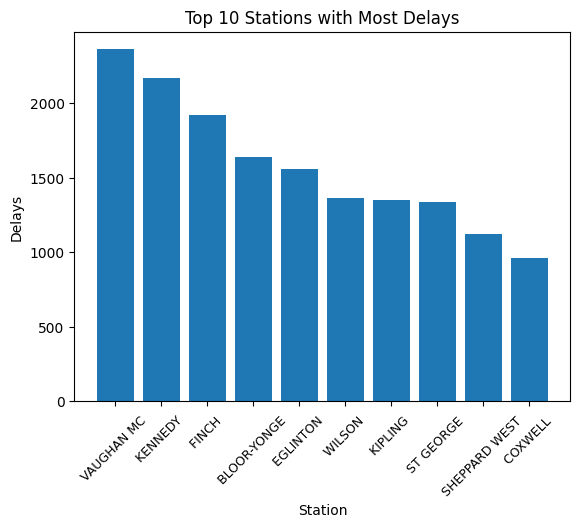

In [ ]:
def stationdelays(df,title):
  station_list=df["Station"].unique().tolist()
  station_counts=df['Station'].value_counts().sort_index()
  sort_station=station_counts.sort_values(ascending=False).head(10) #sort top 10 delay times
  df_stationcounts = pd.DataFrame({'Station': sort_station.index, 'Count': sort_station.values})
  plt.bar(df_stationcounts['Station'], df_stationcounts['Count'])
  plt.xlabel('Station')
  plt.ylabel('Delays')
  plt.title(title)
  plt.xticks(fontsize=9,rotation=45)
  plt.show()
stationdelays(df,'Top 10 Stations with Most Delays')

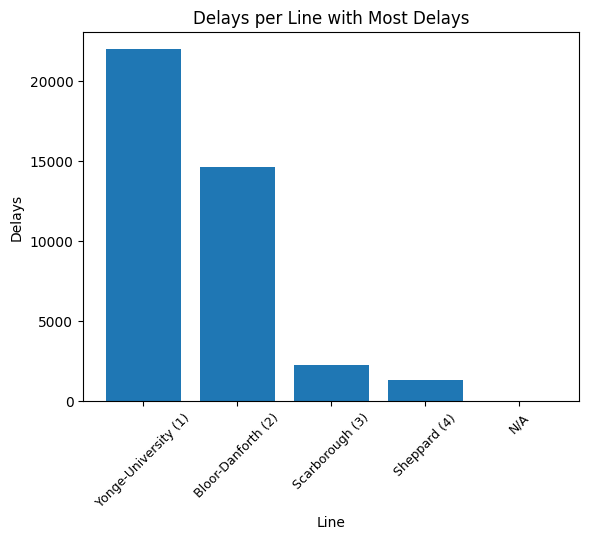

In [ ]:
def linedelays(df,title):
  line_list=df["Line"].unique().tolist()
  line_counts=df['Line'].value_counts().sort_index()
  sort_line=line_counts.sort_values(ascending=False).head(10) #sort lines by delay time
  df_linecounts = pd.DataFrame({'Station': sort_line.index, 'Count': sort_line.values})
  plt.bar(df_linecounts['Station'], df_linecounts['Count'])
  plt.xlabel('Line')
  plt.ylabel('Delays')
  plt.title(title)
  plt.xticks(fontsize=9,rotation=45)
  plt.show()
linedelays(df,'Delays per Line with Most Delays')

In [ ]:
#Total delay time over stations
station_delay_sum = df.groupby('Station')['Min Delay'].sum().reset_index()
station_delay_sum=station_delay_sum.rename(columns={'Min Delay':'Total Min Delay'})
station_delay_sum=station_delay_sum.sort_values(by='Total Min Delay',ascending=False).head(75)
print(station_delay_sum)

             Station  Total Min Delay
31          KENNEDY             15641
4       BLOOR-YONGE             12675
66       VAUGHAN MC             10541
62        ST GEORGE              9760
19         EGLINTON              9465
..               ...              ...
38           LESLIE              1514
48  PIONEER VILLAGE              1416
14   DOWNSVIEW PARK              1372
3         BESSARION              1033
73  YORK UNIVERSITY               903

[75 rows x 2 columns]


In [ ]:
#Incidents by year - get year, count frequency of years
df['Year']=df['Datetime'].dt.year
df['Month']=df['Datetime'].dt.month
df['Day']=df['Datetime'].dt.day
dfCOMP=df.drop(df[df['Year']==2023].index) #remove 2023 from the data as it's not finished
year_count=dfCOMP['Year'].value_counts().reset_index()
year_count.columns=['Year','Count']
year_count=year_count.sort_values(by='Year',ascending=True)
print(year_count.reset_index(drop=True))
print("\n")
month_count=dfCOMP['Month'].value_counts().reset_index()
month_count.columns=['Month','Count']
month_count=month_count.sort_values(by='Month',ascending=True)
print(month_count.reset_index(drop=True))

   Year  Count
0  2018   7050
1  2019   6682
2  2020   6796
3  2021   7321
4  2022   8851


    Month  Count
0       1   3378
1       2   2856
2       3   3074
3       4   3262
4       5   2957
5       6   2792
6       7   3083
7       8   2866
8       9   2885
9      10   3135
10     11   3238
11     12   3174


In [ ]:
df['Month Year']=df['Datetime'].dt.to_period('M')
my_count=df['Month Year'].value_counts().reset_index()
my_count.columns=['Month Year','Count']
my_count=my_count.sort_values(by='Month Year',ascending=True).reset_index(drop=True)
print("In Chronological Order:")
print(my_count)
print("\n")
print("In Descending Order of Incident Frequency:")
print(my_count.sort_values(by='Count',ascending=False))

In Chronological Order:
   Month Year  Count
0     2018-01    696
1     2018-02    527
2     2018-03    568
3     2018-04    487
4     2018-05    596
..        ...    ...
60    2023-01    706
61    2023-02    640
62    2023-03    757
63    2023-04    676
64    2023-05    677

[65 rows x 2 columns]


In Descending Order of Incident Frequency:
   Month Year  Count
27    2020-04    933
48    2022-01    926
46    2021-11    916
47    2021-12    829
57    2022-10    777
..        ...    ...
41    2021-06    499
20    2019-09    491
3     2018-04    487
32    2020-09    432
29    2020-06    384

[65 rows x 2 columns]


In [ ]:
#Including 2023
def timesplit(df):
  year_count=df['Year'].value_counts().reset_index()
  year_count.columns=['Year','Count']
  year_count=year_count.sort_values(by='Year',ascending=True)
  print(year_count.reset_index(drop=True))
  print("\n")
  month_count=df['Month'].value_counts().reset_index()
  month_count.columns=['Month','Count']
  month_count=month_count.sort_values(by='Month',ascending=True)
  print(month_count.reset_index(drop=True))
timesplit(df)

   Year  Count
0  2018   7050
1  2019   6682
2  2020   6796
3  2021   7321
4  2022   8851
5  2023   3456


    Month  Count
0       1   4084
1       2   3496
2       3   3831
3       4   3938
4       5   3634
5       6   2792
6       7   3083
7       8   2866
8       9   2885
9      10   3135
10     11   3238
11     12   3174


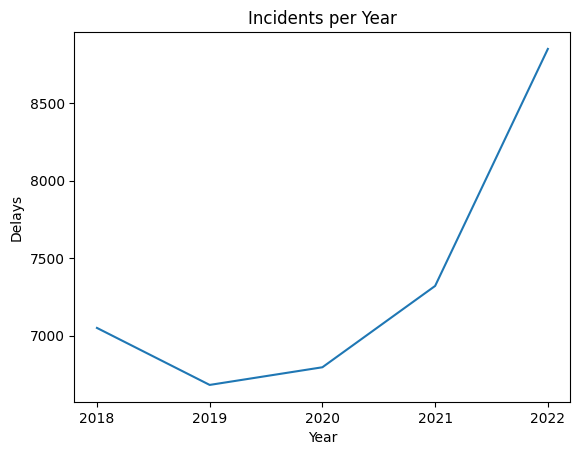

In [ ]:
#Plotting delays by year excluding 2023
def yearplt(df,title):
  year_count=df['Year'].value_counts().reset_index()
  year_count.columns=['Year','Count']
  year_count=year_count.sort_values(by='Year',ascending=True)
  year_count=year_count.drop(year_count[year_count['Year']==2023].index)
  plt.plot(year_count['Year'],year_count['Count'])
  plt.xlabel('Year')
  plt.ylabel('Delays')
  plt.title(title)
  plt.xticks([2018,2019,2020,2021,2022])
  plt.show()
yearplt(df,'Incidents per Year')

   Year  Count
0  2018   1211
1  2019   1210
2  2020   1407
3  2021   1894
4  2022   2259
5  2023   1187


    Month  Count
0       1    947
1       2    854
2       3   1085
3       4    933
4       5    848
5       6    597
6       7    580
7       8    552
8       9    569
9      10    670
10     11    678
11     12    855


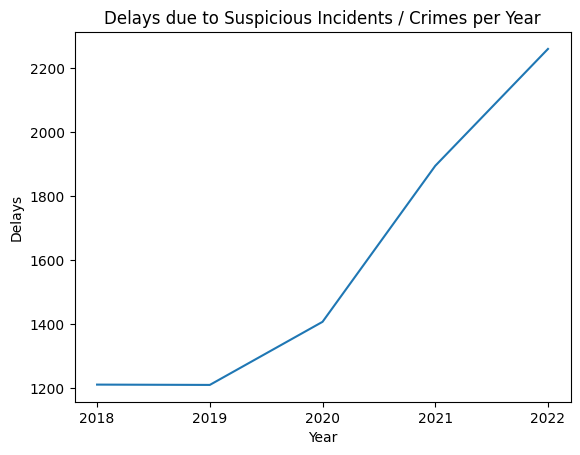

In [ ]:
#Filtering for S crime
df_sus=df[df['Code'].str.startswith('S')]
timesplit(df_sus)
yearplt(df_sus, 'Delays due to Suspicious Incidents / Crimes per Year')

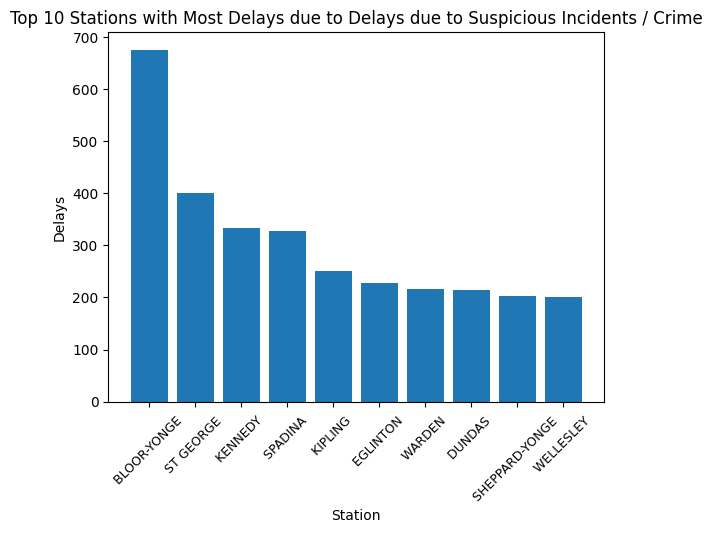

In [ ]:
stationdelays(df_sus,'Top 10 Stations with Most Delays due to Delays due to Suspicious Incidents / Crime')